In [29]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import joblib
from sklearn.preprocessing import MinMaxScaler

In [31]:
# Step 1: 손동작과 레이블 매핑
gesture_to_label = {
    'back': 0, 'space': 1, 'neutral': 2, 'ja1': 3, 'mo1': 4,
    'ja2': 5, 'mo2': 6, 'ja3': 7, 'ja4': 8, 'ja5': 9, 'ja6': 10, 'mo3': 11
}

In [33]:
# Step 2: 시간축 데이터 생성 함수
def create_time_series_data(rms_data, time_steps):
    """
    RMS 데이터에서 시간축(Time Steps) 데이터를 생성.
    """
    time_series_data = []
    for i in range(len(rms_data) - time_steps + 1):
        window = rms_data[i:i+time_steps]  # 연속된 time_steps 개의 RMS 값 선택
        time_series_data.append(window)
    return np.array(time_series_data)

In [35]:
# Step 3: 단일 파일에서 데이터 로드 및 시간축 생성
def load_data_from_file(file_path, label, time_steps):
    """
    단일 txt 파일에서 데이터를 로드하여 시간축 데이터를 생성.
    """
    # txt 파일에서 데이터 로드
    rms_data = np.loadtxt(file_path, delimiter=',')  # RMS 값이 이미 계산된 데이터
    
    # 시간축 데이터 생성
    time_series_data = create_time_series_data(rms_data, time_steps)
    
    # 레이블 추가
    labels = np.full((time_series_data.shape[0],), label)
    return time_series_data, labels

In [37]:
# Step 4: 데이터셋 로드 및 scaler 저장
def load_and_save_dataset(data_dir, time_steps, scaler_path):
    """
    데이터 디렉토리에서 모든 txt 파일 로드 및 정규화 후 scaler 저장.
    """
    X = []
    y = []

    for file_name in os.listdir(data_dir):
        if file_name.endswith(".txt"):
            file_path = os.path.join(data_dir, file_name)
            try:
                # 파일 이름에서 제스처 추출
                parts = os.path.splitext(file_name)[0].split('_')  # 파일명 분리
                if len(parts) < 2:
                    print(f"Skipping file with invalid name format: {file_name}")
                    continue
                
                # `1_ja` 형태를 `ja1`로 변환
                if len(parts) == 2 and parts[1].startswith('ja'):
                    gesture = f"ja{parts[0][-1]}"  # '1_ja' → 'ja1'
                elif len(parts) == 2 and parts[1].startswith('mo'):
                    gesture = f"mo{parts[0][-1]}"  # '2_mo' → 'mo2'
                else:
                    gesture = parts[1]  # 'back', 'space', 'neutral' 같은 단일 제스처 처리
                
                label = gesture_to_label.get(gesture)
                if label is None:
                    print(f"Skipping file with unknown gesture: {file_name}")
                    continue

                # 파일에서 데이터 로드
                time_series_data, labels = load_data_from_file(file_path, label, time_steps)
                
                # 병합
                X.append(time_series_data)
                y.append(labels)
            except Exception as e:
                print(f"Error processing file {file_name}: {e}")
                continue

    # 배열로 변환
    if len(X) == 0 or len(y) == 0:
        raise ValueError("No valid data found in the directory.")

    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)

    print(f"Loaded dataset with shape: X={X.shape}, y={y.shape}")

    # 데이터 정규화 및 scaler 저장
    scaler = MinMaxScaler()
    original_shape = X.shape
    X = X.reshape(-1, X.shape[-1])  # 2D로 변환 (샘플 수 x 채널 수)
    X = scaler.fit_transform(X)  # 정규화
    X = X.reshape(original_shape)  # 원래 형태로 복원

    # Scaler 저장
    joblib.dump(scaler, scaler_path)
    print(f"Scaler saved to {scaler_path}")

    return X, y

In [39]:
def create_cnn(input_shape, num_classes):
    """
    CNN 모델 정의.
    """
    model = models.Sequential()

    # Input Layer
    model.add(layers.Input(shape=input_shape))

    # Conv2D 레이어
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 1)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 1)))

    # Fully Connected Layer
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # 모델 컴파일
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [41]:
# Step 6: 데이터 경로 및 파라미터 설정
data_dir = "../data"  # 데이터 디렉토리 경로
time_steps = 10  # 시간축 RMS 값 개수 (1초에 10개 RMS 값)
scaler_path = "scaler.pkl"  # Scaler 저장 경로

In [43]:
# Step 7: 데이터 로드 및 정규화
X, y = load_and_save_dataset(data_dir, time_steps, scaler_path)

Skipping file with invalid name format: rms.txt
Loaded dataset with shape: X=(11892, 10, 8), y=(11892,)
Scaler saved to scaler_jae.pkl


In [45]:
# CNN 입력 형태로 변환
X = X[..., np.newaxis]  # (샘플 수, Time Steps, Channels, Depth)

In [47]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [49]:
# Step 8: CNN 모델 생성
input_shape = (time_steps, X.shape[2], 1)  # (Time Steps, 채널 수, Depth)
num_classes = len(set(y))
model = create_cnn(input_shape, num_classes)

Epoch 1/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4553 - loss: 1.6261 - val_accuracy: 0.9476 - val_loss: 0.2264
Epoch 2/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9146 - loss: 0.3114 - val_accuracy: 0.9661 - val_loss: 0.1222
Epoch 3/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9428 - loss: 0.1997 - val_accuracy: 0.9658 - val_loss: 0.1014
Epoch 4/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9561 - loss: 0.1439 - val_accuracy: 0.9737 - val_loss: 0.0811
Epoch 5/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9576 - loss: 0.1274 - val_accuracy: 0.9767 - val_loss: 0.0708
Epoch 6/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9655 - loss: 0.1093 - val_accuracy: 0.9773 - val_loss: 0.0642
Epoch 7/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9628 - loss: 0.1109 - val_accuracy: 0.9801 - val_loss: 0.0564
Epoch 8/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9675 - loss: 0.1035 - val_accuracy: 0.

Epoch 1/20:
 - Train Accuracy: 0.6710, Validation Accuracy: 0.9476
 - Train Loss: 1.0135, Validation Loss: 0.2264
Epoch 2/20:
 - Train Accuracy: 0.9252, Validation Accuracy: 0.9661
 - Train Loss: 0.2682, Validation Loss: 0.1222
Epoch 3/20:
 - Train Accuracy: 0.9419, Validation Accuracy: 0.9658
 - Train Loss: 0.1886, Validation Loss: 0.1014
Epoch 4/20:
 - Train Accuracy: 0.9557, Validation Accuracy: 0.9737
 - Train Loss: 0.1498, Validation Loss: 0.0811
Epoch 5/20:
 - Train Accuracy: 0.9572, Validation Accuracy: 0.9767
 - Train Loss: 0.1286, Validation Loss: 0.0708
Epoch 6/20:
 - Train Accuracy: 0.9634, Validation Accuracy: 0.9773
 - Train Loss: 0.1111, Validation Loss: 0.0642
Epoch 7/20:
 - Train Accuracy: 0.9658, Validation Accuracy: 0.9801
 - Train Loss: 0.1021, Validation Loss: 0.0564
Epoch 8/20:
 - Train Accuracy: 0.9704, Validation Accuracy: 0.9818
 - Train Loss: 0.0926, Validation Loss: 0.0523
Epoch 9/20:
 - Train Accuracy: 0.9724, Validation Accuracy: 0.9821
 - Train Loss: 0.0809

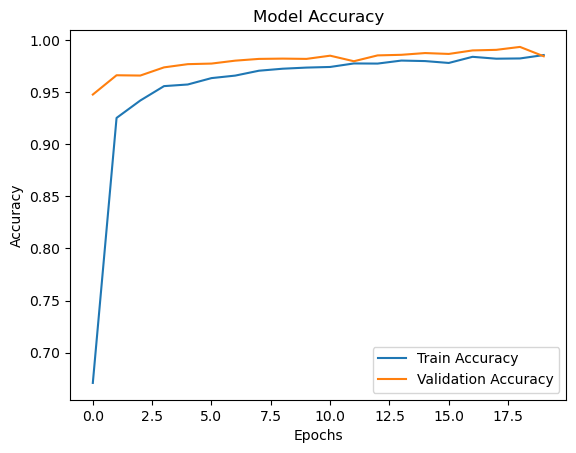

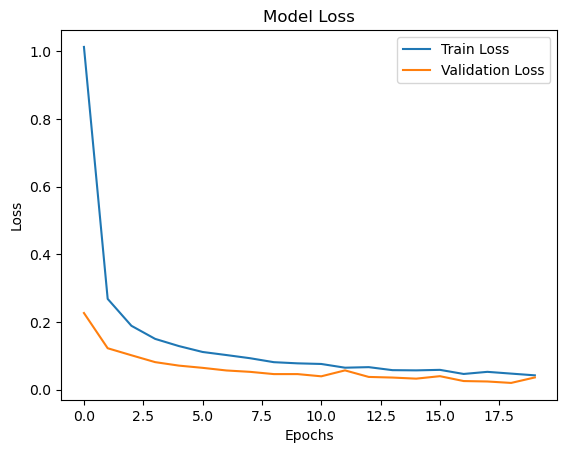

In [51]:
# Step 9: 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

# 에폭마다의 상황 출력
for epoch in range(len(history.history['accuracy'])):
    train_acc = history.history['accuracy'][epoch]
    val_acc = history.history['val_accuracy'][epoch]
    train_loss = history.history['loss'][epoch]
    val_loss = history.history['val_loss'][epoch]
    print(f"Epoch {epoch + 1}/{len(history.history['accuracy'])}:")
    print(f" - Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    print(f" - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# 모델 저장
model.save("cnn_model.h5")
print("Model saved to cnn_model.h5")

# 그래프 출력
import matplotlib.pyplot as plt

# 학습 정확도와 검증 정확도 시각화
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# 학습 손실과 검증 손실 시각화
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


In [53]:
# Step 10: 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

112/112 - 0s - 2ms/step - accuracy: 0.9843 - loss: 0.0358
Test Accuracy: 98.43%


In [55]:
# 훈련 및 검증 정확도 비교
train_acc = history.history['accuracy'][-1]  # 마지막 에폭의 훈련 정확도
val_acc = history.history['val_accuracy'][-1]  # 마지막 에폭의 검증 정확도

train_loss = history.history['loss'][-1]  # 마지막 에폭의 훈련 손실
val_loss = history.history['val_loss'][-1]  # 마지막 에폭의 검증 손실

print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

# 과적합 여부 판별
if val_acc < train_acc and (train_acc - val_acc) > 0.05:
    print("Potential Overfitting Detected: Training accuracy is significantly higher than validation accuracy.")
else:
    print("No significant overfitting detected.")

Final Training Accuracy: 98.55%
Final Validation Accuracy: 98.43%
Final Training Loss: 0.0420
Final Validation Loss: 0.0358
No significant overfitting detected.
